# Autho labeling with Grounding dino

**Grouding Dino used only to auto-label yolo style**


In [1]:
import argparse
import os
import copy

import numpy as np
import json
import torch
from PIL import Image, ImageDraw, ImageFont

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap

# segment anything
# from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt

# torch transform
import torchvision.transforms as TT

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/home/gea-ai/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/gea-ai/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any 

## Utils

In [2]:
def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

In [3]:
def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    print(load_res)
    _ = model.eval()
    return model

In [4]:
def get_grounding_output(model, image, caption, box_threshold, text_threshold, with_logits=True, device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
        if with_logits:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        else:
            pred_phrases.append(pred_phrase)

    return boxes_filt, pred_phrases

In [5]:
def show_mask(mask, ax, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [6]:
def show_box(box, ax, label):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 
    ax.text(x0, y0, label)

# Load Grounding Dino Model

In [7]:
# Use this command for evaluate the Grounding DINO model
config_file = "GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py"
grounded_checkpoint = "GroundingDINO/weights/groundingdino_swinb_cogcoor.pth"
device = "cuda"


In [8]:
# groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)
groundingdino_model = load_model(config_file, grounded_checkpoint, device=device)

/home/gea-ai/anaconda3/envs/torch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


# Load SAM model (do not use)

In [9]:
# sam_checkpoint = 'weights/sam_vit_h_4b8939.pth'
# sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

# Load demo image

In [10]:
local_image_path = 'assets/test.jpg'

# Run Grounding DINO for detection

In [11]:
TEXT_PROMPT = "cauliflower . broccoli . zucchini"
BOX_TRESHOLD = 0.30
TEXT_TRESHOLD = 0.25

image_pil, image = load_image(local_image_path)

# run grounding dino model
boxes_filt, pred_phrases = get_grounding_output(
    groundingdino_model, image, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD, device=device
)


/home/gea-ai/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/gea-ai/anaconda3/envs/torch/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


# Run the segmentation model (not using)

In [16]:
# set image
image = cv2.imread(local_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# sam_predictor.set_image(image)

In [13]:
size = image_pil.size
H, W = size[1], size[0]
for i in range(boxes_filt.size(0)):
    boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
    boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
    boxes_filt[i][2:] += boxes_filt[i][:2]

boxes_filt = boxes_filt.cpu()
# transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(device)

# masks, _, _ = sam_predictor.predict_torch(
#     point_coords = None,
#     point_labels = None,
#     boxes = transformed_boxes.to(device),
#     multimask_output = False,
# )

In [14]:
print(image.shape)
print(len(boxes_filt), len(pred_phrases))


torch.Size([3, 800, 800])
12 12


(-0.5, 719.5, 719.5, -0.5)

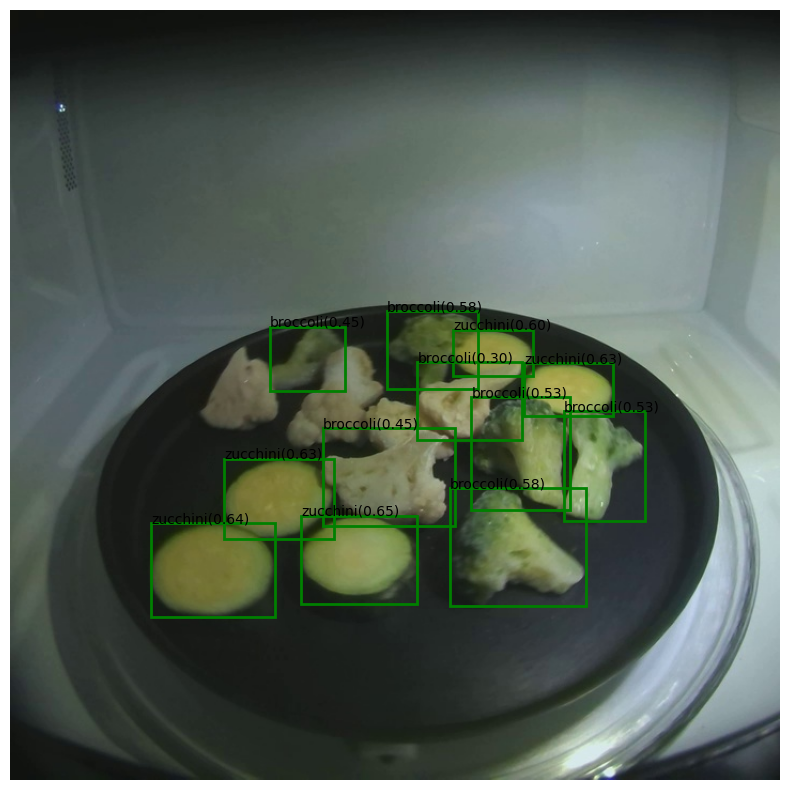

In [17]:
# draw output image
plt.figure(figsize=(10, 10))
plt.imshow(image)
# for mask in masks:
#     show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box, label in zip(boxes_filt, pred_phrases):
    show_box(box.numpy(), plt.gca(), label)

plt.axis('off')

In [ ]:
# len(masks)

# Make masks without SAM

In [46]:
masks = []
for box in boxes_filt:
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    x_min, y_min, x_max, y_max = map(int, box.tolist())
    mask[y_min:y_max, x_min:x_max] = 1
    masks.append(mask)
print(len(masks))
for mask in masks:
    print(mask.shape)


12
(720, 720)
(720, 720)
(720, 720)
(720, 720)
(720, 720)
(720, 720)
(720, 720)
(720, 720)
(720, 720)
(720, 720)
(720, 720)
(720, 720)


## Yolov8 format annotation

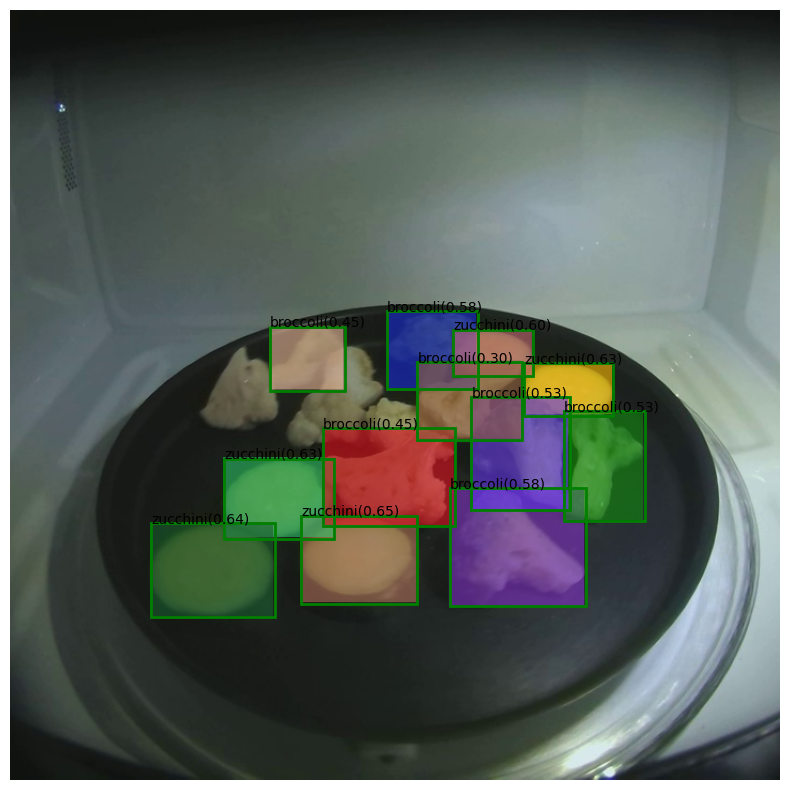

In [25]:
for i, mask in enumerate(masks):

    binary_mask = mask.squeeze().astype(np.uint8)

    # Find the contours of the mask
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    # Get the new bounding box
    bbox = [int(x) for x in cv2.boundingRect(largest_contour)]

    # Get the segmentation mask for object 
    segmentation = largest_contour.flatten().tolist()

    # Write bounding boxes to file in YOLO format
    with open('BBOX_yolo.txt', 'w') as f:
        for contour in contours:
            # Get the bounding box coordinates of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Convert the coordinates to YOLO format and write to file
            f.write('0 {:.6f} {:.6f} {:.6f} {:.6f}\n'.format((x+w/2)/image.shape[1], (y+h/2)/image.shape[0], w/image.shape[1], h/image.shape[0]))
            f.write('\n')
    mask=segmentation
    
    # load the image
    #width, height = image_path.size
    img = Image.open(local_image_path)
    width, height = img.size

    # convert mask to numpy array of shape (N,2)
    mask = np.array(mask).reshape(-1,2)

    # normalize the pixel coordinates
    mask_norm = mask / np.array([width, height])

    # compute the bounding box
    xmin, ymin = mask_norm.min(axis=0)
    xmax, ymax = mask_norm.max(axis=0)
    bbox_norm = np.array([xmin, ymin, xmax, ymax])

    # concatenate bbox and mask to obtain YOLO format
    yolo = np.concatenate([bbox_norm, mask_norm.reshape(-1)])

    # compute the bounding box
    # write the yolo values to a text file
    with open('yolomask_format.txt', 'w') as f:
        for val in yolo:
            f.write("{:.6f} ".format(val))
        f.write('\n')

    # Print the bounding box and segmentation mask
#     print("Bounding box:", bbox)
    #print("Segmentation mask:", segmentation)
#     print("yolo",yolo)
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
for box, label in zip(boxes_filt, pred_phrases):
    show_box(box.numpy(), plt.gca(), label)
plt.axis('off')
plt.show()

## COCO Utils

In [39]:
pip install Shapely

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.2 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [40]:
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)
import datetime
import json
from pycocotools.coco import COCO

def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)=
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')

    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area
    }

    return annotation


def create_image_info(image_id, file_name, image_size, 
                      date_captured=datetime.datetime.utcnow().isoformat(' '),
                      license_id=1, coco_url="", flickr_url=""):

    image_info = {
            "id": image_id,
            "file_name": file_name,
            "width": image_size[0],
            "height": image_size[1],
            "date_captured": date_captured,
            "license": license_id,
            "coco_url": coco_url,
            "flickr_url": flickr_url
    }

    return image_info


def IOUcalc(registered, cand_area, thresh):
    for bbox in registered:
        iou = get_iou(bbox, cand_area)
        if iou >= float(thresh):
            return False
        else:
            continue
    return True


def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou    

### COCO Annotation

In [52]:
CAT_ID = {'asparagus': 1, 'broccoli': 2, 'carrot': 3, 'cauliflower': 4, 'potato': 5, 'zucchini': 6}
IOU_THRESHOLD = 0.8

# COCO dict
coco_annotation = {"images":[], "annotations":[], "categories":[]}

# Set dafault categories values
coco_annotation["categories"].append({"supercategory":None, "id":0, "name":"_background_"})

for i, category in enumerate(CAT_ID.keys()):
    print(i, category)
    coco_annotation["categories"].append({"supercategory":None, "id":i+1, "name":category})

print(coco_annotation["categories"])

# mask conversion method
transform = TT.ToPILImage()

# default values (not directly-effective to model training)
image_id = 0
annotation_id = 0
is_crowd = 0
registerd_regions = []

# run iteration for attaching object on 1 image
for i, (box, label) in enumerate(zip(boxes_filt, pred_phrases)):
    # bbox conversion to tensor --> dict
    bbox = {}
    bbox['x1'], bbox['x2'], bbox['y1'], bbox['y2'] = box[0], box[2], box[1], box[3]
    
    try:
        category_id = int(CAT_ID[label.split('(')[0]])
    except:
        category_id = int(CAT_ID[label.split('(')[0].split(' ')[0]])
#     print(category_id)
    mask = masks[i]
    print(mask.shape)
    print(mask.size)
    
    
    # mask squeeze & conversion 
    # squeezed_mask = np.squeeze(mask, axis=0) #torch.squeeze(mask, 0)
    # squeezed_mask = transform(np.uint8(squeezed_mask.cpu()))
    
    # To check whether multiple bounding boxes are detected for a single objects
    if IOUcalc(registerd_regions, bbox, IOU_THRESHOLD):
        # add bbox area for IoU calc.
        registerd_regions.append(bbox)
        annotation = create_sub_mask_annotation(np.asarray(mask), image_id, category_id, annotation_id, is_crowd)
        coco_annotation["annotations"].append(annotation)                    
        annotation_id += 1
        
image_info = create_image_info(image_id, local_image_path, mask.shape)
coco_annotation["images"].append(image_info)

# Save COCO Annotation
with open('multi_class_test_annotation.json', 'w') as outfile:
    json.dump(coco_annotation, outfile)


0 asparagus
1 broccoli
2 carrot
3 cauliflower
4 potato
5 zucchini
[{'supercategory': None, 'id': 0, 'name': '_background_'}, {'supercategory': None, 'id': 1, 'name': 'asparagus'}, {'supercategory': None, 'id': 2, 'name': 'broccoli'}, {'supercategory': None, 'id': 3, 'name': 'carrot'}, {'supercategory': None, 'id': 4, 'name': 'cauliflower'}, {'supercategory': None, 'id': 5, 'name': 'potato'}, {'supercategory': None, 'id': 6, 'name': 'zucchini'}]
(720, 720)
518400
(720, 720)
518400
(720, 720)
518400
(720, 720)
518400
(720, 720)
518400
(720, 720)
518400
(720, 720)
518400
(720, 720)
518400
(720, 720)
518400
(720, 720)
518400
(720, 720)
518400
(720, 720)
518400


In [53]:
coco_annotation

{'images': [{'id': 0,
   'file_name': 'assets/test.jpg',
   'width': 720,
   'height': 720,
   'date_captured': '2025-01-22 01:33:47.492290',
   'license': 1,
   'coco_url': '',
   'flickr_url': ''}],
 'annotations': [{'segmentation': [[378.0,
     552.5,
     270.0,
     552.5,
     269.5,
     471.0,
     378.0,
     470.5,
     378.0,
     552.5]],
   'iscrowd': 0,
   'image_id': 0,
   'category_id': 6,
   'id': 0,
   'bbox': (269.5, 470.5, 108.5, 82.0),
   'area': 8849.5},
  {'segmentation': [[300.0,
     491.5,
     198.0,
     491.5,
     197.5,
     417.0,
     300.0,
     416.5,
     300.0,
     491.5]],
   'iscrowd': 0,
   'image_id': 0,
   'category_id': 6,
   'id': 1,
   'bbox': (197.5, 416.5, 102.5, 75.0),
   'area': 7643.25},
  {'segmentation': [[244.0,
     565.5,
     130.0,
     565.5,
     129.5,
     478.0,
     244.0,
     477.5,
     244.0,
     565.5]],
   'iscrowd': 0,
   'image_id': 0,
   'category_id': 6,
   'id': 2,
   'bbox': (129.5, 477.5, 114.5, 88.0),
   'a